In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 1
%aimport joint_prob

In [2]:
font_size = 12
plt.rc('font', size=font_size)
plt.rc('axes', titlesize=font_size)
plt.rc('axes', labelsize=font_size)
plt.rc('xtick', labelsize=font_size)
plt.rc('ytick', labelsize=font_size)
plt.rc('legend', fontsize=font_size)
plt.rc('figure', titlesize=font_size)

In [3]:
import pickle
# df = pd.read_csv('../datasets/D.txt', sep=';', index_col=0, parse_dates=True)
with open('../datasets/D.pkl', 'rb') as f:
    df = pickle.load(f)
df.head(2)

,wind speed (m/s),significant wave height (m)
time (YYYY-MM-DD-HH),,
1965-01-01 00:00:00,15.3839,3.9879
1965-01-01 01:00:00,15.4990,4.0086


In [37]:
class Multivariate:
    std_norm = stats.norm()
    def __init__(self, df, col_x=0, col_y=1, condY_x=None):
        self.x = df.iloc[:, col_x]
        self.y = df.iloc[:, col_y]
        if condY_x is None:
            self.condY_x = np.linspace(x.min(), x.max(), 10)
        else:
            self.condY_x = condY_x
        self.condY_dx = np.diff(condY_x).mean()
        

    def fit(self, plot_diagnosis=True, verbose=True):
        total_steps = 5
        if verbose:
            print(f'Step 1/{total_steps}: Fitting marginal X')
        x_pd = joint_prob.Univariate(self.x, sample_coor=np.linspace(0, 2*self.x.max(), 1000))
        x_pd.fit(method_maxima='Annual', method_tail='GumbelChart', method_bulk='Empirical', 
                 outlier_detect=False, verbose=False)
        self.x_pd = x_pd
        
        if verbose:
            print(f'Step 2/{total_steps}: Fitting marginal Y')
        y_pd = joint_prob.Univariate(self.y, sample_coor=np.linspace(0, 2*self.y.max(), 1000))
        y_pd.fit(method_maxima='Annual', method_tail='GumbelChart', method_bulk='Empirical', 
                 outlier_detect=False, verbose=False)
        self.y_pd = y_pd
        
        if verbose:
            print(f'Step 3/{total_steps}: Fitting conditional Y')
        condY_pd = []
        for cur_x in self.condY_x:
            condY_data = self.y.copy()
            condY_data[(self.x < cur_x - self.condY_dx) | (self.x > cur_x + self.condY_dx)] = np.nan
            cur_pd = joint_prob.Univariate(condY_data, sample_coor=np.linspace(0, 2*self.x.max(), 1000))
            cur_pd.fit(method_maxima='Annual', method_tail='GumbelChart', method_bulk='Empirical', 
                     outlier_detect=False, verbose=False)
            condY_pd.append(cur_pd)
        self.condY_pd = condY_pd
        
        
    def predict(self, MRPs):
        ''' Construct environmental contour 
            Parameters:
            -----------
                MRP: numpy array. Target MRP
        '''
        
        def get_condY_F(x_pd, beta, x):
            ''' Return F of condY given beta '''
            x_F = interp1d(x_pd.sample_coor, x_pd.sample_F)(x)
            x_beta = std_norm.ppf(x_F)
            y_beta_square = beta ** 2 - x_beta ** 2
            y_beta_square[y_beta_square < 0] = np.nan
            y_beta = np.sqrt(y_beta_square)
            y_F = std_norm.cdf(y_beta)
            return y_beta
        
        for MRP in MRPs:
            beta = std_norm.ppf(1 - 1/self.x_pd.c_rate/MRP)
            
            # MRP of independent Y for validation
            y_mrp = self.y_pd.predict(MRP=MRP)

            # Jagged contour
            condY_F = get_condY_F(self.x_pd, beta, self.condY_x)

            # Determine range of re-parameterization

            # Upper contour

            # Lower contour

            # Combine result
    
    
        
    def plot_diagnosis(self):
        def plot_pd_diagnosis():
            if ' ' in dropdown_pd.value: # contains list index
                attr_name, idx = dropdown_pd.value.split(sep=' ')
                pd = getattr(self, attr_name)[int(idx)]
            else:
                pd = getattr(self, dropdown_pd.value)
            display(pd.diag_fig)

        def update_pd_plot(change):
            pd_display.clear_output(wait=True)
            with pd_display:
                plot_pd_diagnosis()
                plt.show()

        # Tab 1: Univirate fitting
        dropdown_options = [('Marginal X', 'x_pd'), ('Marginal Y', 'y_pd')] +\
            [('Conditional Y at X={:.1f}'.format(condY_x), 'condY_pd {}'.format(idx)) 
             for idx, condY_x in enumerate(self.condY_x)]
        dropdown_pd = widgets.Dropdown(options=dropdown_options, description='Item')
        dropdown_pd.observe(update_pd_plot, names="value")
        pd_display = widgets.Output()
        with pd_display:
            plot_pd_diagnosis()
            plt.show()
        tab1 = widgets.VBox(children=[dropdown_pd, pd_display])

        # Tab 2: Multivirate fitting
        tab2 = widgets.VBox(children=[])

        tab = widgets.Tab(children=[tab1, tab2])
        tab.set_title(0, 'Univariate fitting')
        tab.set_title(1, 'Multivariate fitting')
        return widgets.VBox(children=[tab])

self = Multivariate(df, condY_x=np.arange(1, 22))
self.fit()
# self.plot_diagnosis()

Step 1/5: Fitting marginal X
Step 2/5: Fitting marginal Y
Step 3/5: Fitting conditional Y


In [38]:
self.x_pd.sample_F

array([0.00000000e+00, 1.30188984e-06, 2.76164566e-06, 8.98296474e-06,
       4.55099285e-05, 1.59835630e-04, 3.40553035e-04, 5.48402778e-04,
       8.95668813e-04, 1.34294609e-03, 1.80511012e-03, 2.58463744e-03,
       3.32433856e-03, 4.20572589e-03, 5.20991922e-03, 6.45142216e-03,
       7.69393653e-03, 8.91114722e-03, 1.03267086e-02, 1.17675219e-02,
       1.33537102e-02, 1.50186139e-02, 1.69098725e-02, 1.89287057e-02,
       2.08380904e-02, 2.27589204e-02, 2.49706005e-02, 2.72321987e-02,
       2.96078025e-02, 3.18743289e-02, 3.42029748e-02, 3.67175623e-02,
       3.95075774e-02, 4.23407992e-02, 4.53522738e-02, 4.82209140e-02,
       5.16296854e-02, 5.46318340e-02, 5.76987682e-02, 6.12563203e-02,
       6.45302836e-02, 6.80357021e-02, 7.16550539e-02, 7.53176625e-02,
       7.91611435e-02, 8.33025029e-02, 8.70188491e-02, 9.09040340e-02,
       9.48528296e-02, 9.87611046e-02, 1.02859002e-01, 1.07140238e-01,
       1.11362152e-01, 1.15844247e-01, 1.20105549e-01, 1.24271680e-01,
      

In [17]:
std_norm = stats.norm()
MRP = 50

In [22]:
def get_condY_F(x_pd, beta, x):
    ''' Return F of condY given beta '''
    x_F = interp1d(x_pd.sample_coor, x_pd.sample_F)(x)
    x_beta = std_norm.ppf(x_F)
    y_beta_square = beta ** 2 - x_beta ** 2
    y_beta_square[y_beta_square < 0] = np.nan
    y_beta = np.sqrt(y_beta_square)
    y_F = std_norm.cdf(y_beta)
    return y_F

In [26]:
def get_jaggaed_contour(condY_pd, condY_F):
    return np.array([interp1d(pd.sample_F, pd.sample_coor)(F) 
                     for pd, F in zip(condY_pd, condY_F)])

In [39]:
beta = std_norm.ppf(1 - 1/self.x_pd.c_rate/MRP)

# MRP of independent Y for validation
y_mrp = self.y_pd.predict(MRP=MRP)

# Jagged contour
condY_F = get_condY_F(self.x_pd, beta, self.condY_x)
contour_jag_top = get_jaggaed_contour(self.condY_pd, condY_F)
contour_jag_bot = get_jaggaed_contour(self.condY_pd, 1 - condY_F)

# Determine range of re-parameterization

# Upper contour

# Lower contour

# Combine result

In [46]:
contour_jag_bot

array([0.05922169, 0.0401788 , 0.02840144, 0.02698286, 0.03298061,
       0.03620441, 0.04958339, 0.05095141, 0.06951354, 0.09819995,
       0.1028812 , 0.13055759, 0.14697742, 0.1743486 , 0.18833855,
       0.21144297, 0.23813587, 0.27216586, 0.36743272, 0.48048122,
       0.50711759])

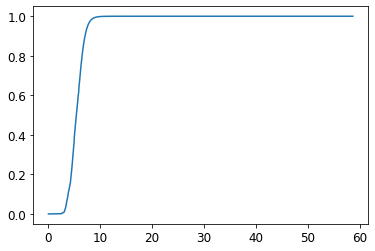

In [48]:
plt.plot(self.condY_pd[-2].sample_coor, self.condY_pd[-2].sample_F)
plt.show()

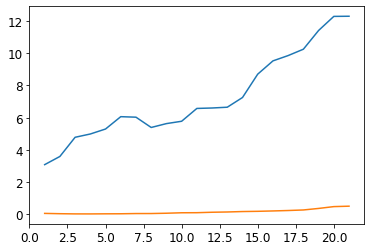

In [40]:
plt.plot(self.condY_x, contour_jag_top)
plt.plot(self.condY_x, contour_jag_bot)
plt.show()